importing needed libraries

# Importing needed libraries
# Part two of the project: Improving the created models  
# Section 1: Feature extraction
# Section 2: Feature selection

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Fetching historical data for a specific stock (e.g., AAPL)

In [3]:
ticker = 'AAPL'  # Stock ticker symbol
data = yf.download(ticker, start='2024-01-01', end='2025-01-22')

[*********************100%%**********************]  1 of 1 completed


# Step 1: Examining the structure of the data

In [4]:
print("Head of the dataset:\n", data.head())
print("\n")
print("Information about dataset:\n", data.info())
print("\n")
print("Descriptive statistics:\n", data.describe())

Head of the dataset:
                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-01-02  187.149994  188.440002  183.889999  185.639999  184.734970   
2024-01-03  184.220001  185.880005  183.429993  184.250000  183.351746   
2024-01-04  182.149994  183.089996  180.880005  181.910004  181.023163   
2024-01-05  181.990005  182.759995  180.169998  181.179993  180.296707   
2024-01-08  182.089996  185.600006  181.500000  185.559998  184.655365   

              Volume  
Date                  
2024-01-02  82488700  
2024-01-03  58414500  
2024-01-04  71983600  
2024-01-05  62303300  
2024-01-08  59144500  


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 264 entries, 2024-01-02 to 2025-01-21
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       264 non-null    float64
 1   High       264 non-null    float64
 2   Low     

# Step 2: Checking for missing values


In [5]:
print("Missing values before cleaning:\n", data.isnull().sum())
data.dropna(inplace=True)   # Dropping rows with missing 
print("Missing values after cleaning:\n", data.isnull().sum())

Missing values before cleaning:
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Missing values after cleaning:
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


# Step 3: Examining the distribution of the data

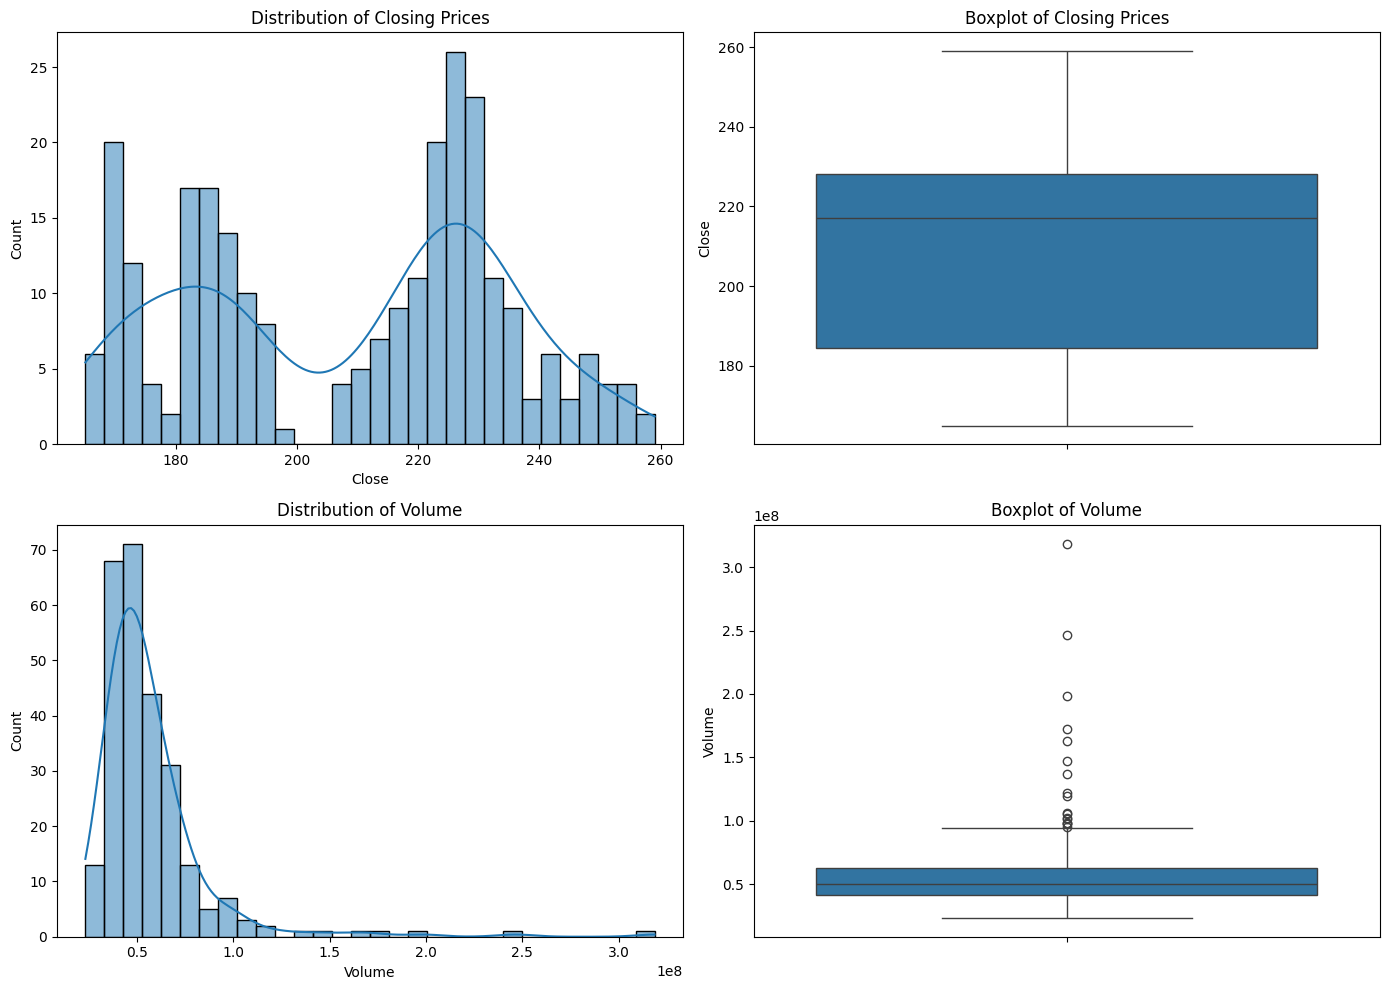

In [ ]:
plt.figure(figsize=(14, 10))

# Histogram of closing prices
plt.subplot(2, 2, 1)
sns.histplot(data['Close'], bins=30, kde=True)
plt.title('Distribution of Closing Prices')

# Boxplot of closing prices
plt.subplot(2, 2, 2)
sns.boxplot(y=data['Close'])
plt.title('Boxplot of Closing Prices')

# Histogram of trading volume
plt.subplot(2, 2, 3)
sns.histplot(data['Volume'], bins=30, kde=True)
plt.title('Distribution of Volume')

# Boxplot of trading volume
plt.subplot(2, 2, 4)
sns.boxplot(y=data['Volume'])
plt.title('Boxplot of Volume')

plt.tight_layout()
plt.show()

# Step 4: Examining trends and patterns and creating indicators

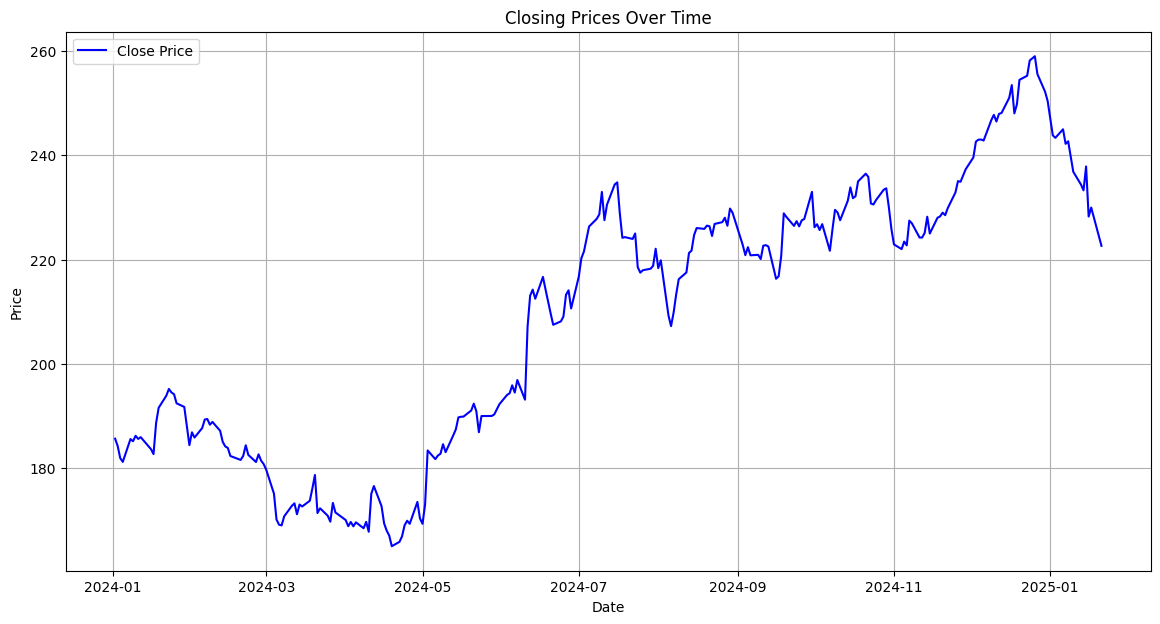

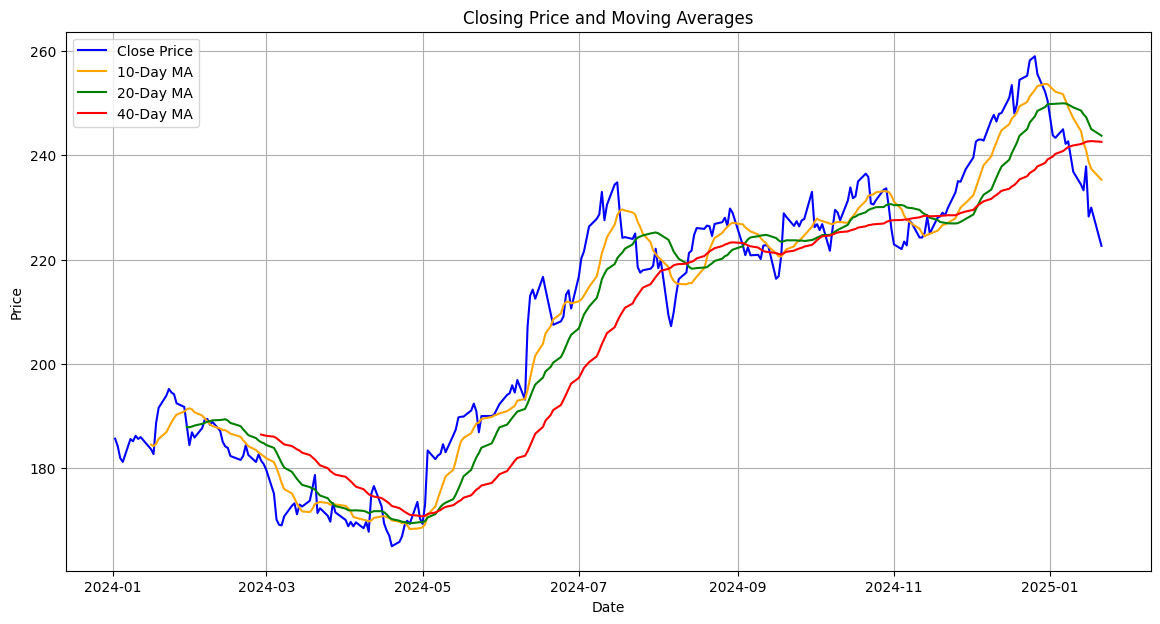

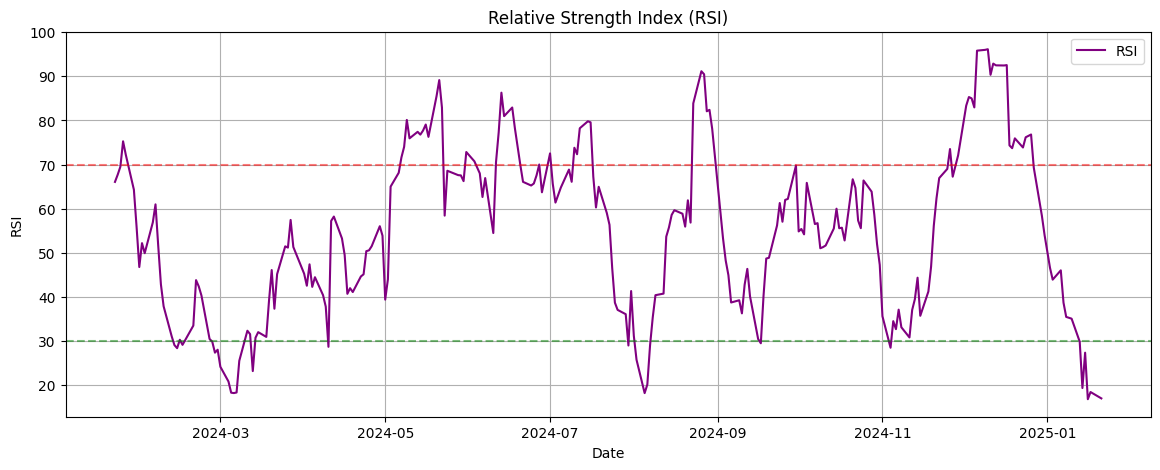

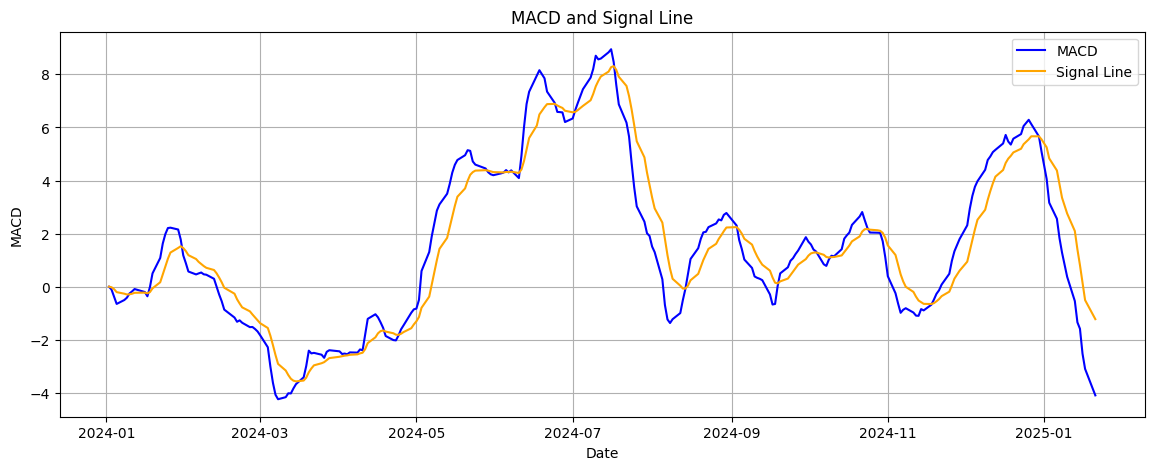

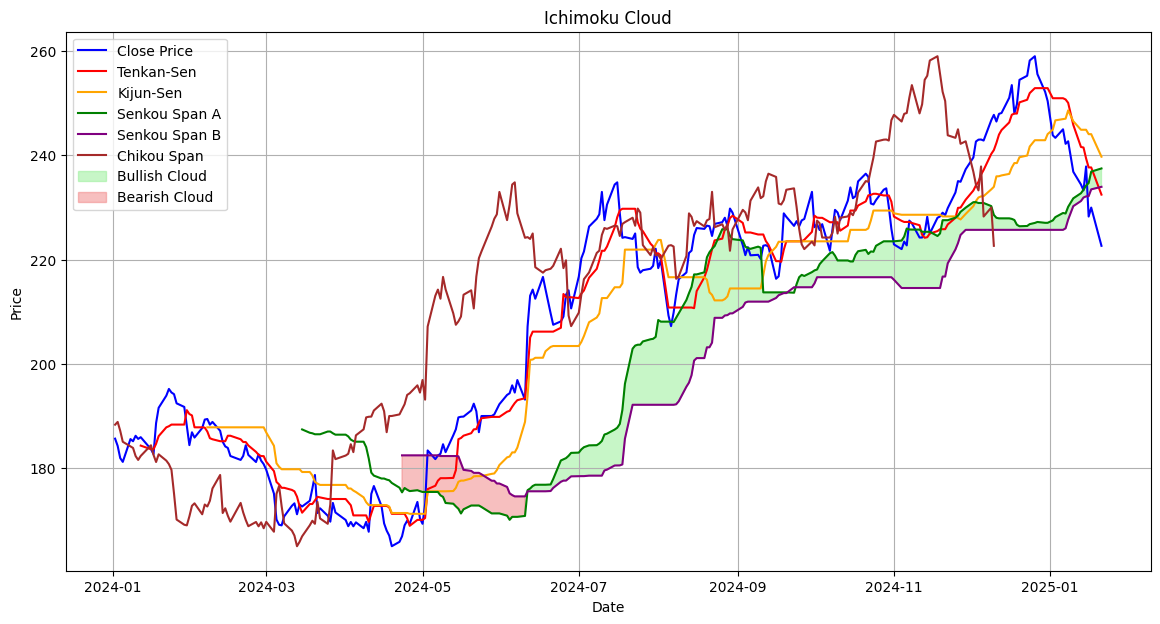

In [7]:
plt.figure(figsize=(14, 7))

# Feature extraction
# Closing price over time
plt.plot(data.index, data['Close'], label='Close Price', color='blue')
plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

# Calculating moving averages
data['MA10'] = data['Close'].rolling(window=10).mean()
data['MA20'] = data['Close'].rolling(window=20).mean()
data['MA40'] = data['Close'].rolling(window=40).mean()

# Plotting closing price and moving averages
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Close Price', color='blue')
plt.plot(data['MA10'], label='10-Day MA', color='orange')
plt.plot(data['MA20'], label='20-Day MA', color='green')
plt.plot(data['MA40'], label='40-Day MA', color='red')
plt.title('Closing Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

# Calculating RSI (14-day)
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

data['RSI'] = calculate_rsi(data)

# Plotting RSI
plt.figure(figsize=(14, 5))
plt.plot(data['RSI'], label='RSI', color='purple')
plt.axhline(70, linestyle='--', alpha=0.5, color='red')   # Overbought line
plt.axhline(30, linestyle='--', alpha=0.5, color='green')   # Oversold line
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.grid()
plt.show()

# Calculating MACD
def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    exp1 = data['Close'].ewm(span=short_window, adjust=False).mean()
    exp2 = data['Close'].ewm(span=long_window, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

data['MACD'], data['Signal'] = calculate_macd(data)

# Plotting MACD
plt.figure(figsize=(14, 5))
plt.plot(data['MACD'], label='MACD', color='blue')
plt.plot(data['Signal'], label='Signal Line', color='orange')
plt.title('MACD and Signal Line')
plt.xlabel('Date')
plt.ylabel('MACD')
plt.legend()
plt.grid()
plt.show()

# Calculating Ichimoku
def calculate_ichimoku(data):
    high_9 = data['High'].rolling(window=9).max()
    low_9 = data['Low'].rolling(window=9).min()
    data['Tenkan-Sen'] = (high_9 + low_9) / 2  # Tenkan line

    high_26 = data['High'].rolling(window=26).max()
    low_26 = data['Low'].rolling(window=26).min()
    data['Kijun-Sen'] = (high_26 + low_26) / 2  # Kijun line

    data['Senkou Span A'] = ((data['Tenkan-Sen'] + data['Kijun-Sen']) / 2).shift(26)  # Senkou Span A
    data['Senkou Span B'] = ((data['High'].rolling(window=52).max() + data['Low'].rolling(window=52).min()) / 2).shift(26)  # Senkou Span B
    data['Chikou Span'] = data['Close'].shift(-26)  # Chikou Span

calculate_ichimoku(data)

# Plotting Ichimoku
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Close Price', color='blue')
plt.plot(data['Tenkan-Sen'], label='Tenkan-Sen', color='red')
plt.plot(data['Kijun-Sen'], label='Kijun-Sen', color='orange')
plt.plot(data['Senkou Span A'], label='Senkou Span A', color='green')
plt.plot(data['Senkou Span B'], label='Senkou Span B', color='purple')
plt.plot(data['Chikou Span'], label='Chikou Span', color='brown')
plt.title('Ichimoku Cloud')
plt.xlabel('Date')
plt.ylabel('Price')
plt.fill_between(data.index, data['Senkou Span A'], data['Senkou Span B'], where=(data['Senkou Span A'] >= data['Senkou Span B']), color='lightgreen', alpha=0.5, label='Bullish Cloud')
plt.fill_between(data.index, data['Senkou Span A'], data['Senkou Span B'], where=(data['Senkou Span A'] < data['Senkou Span B']), color='lightcoral', alpha=0.5, label='Bearish Cloud')
plt.legend()
plt.grid()
plt.show()


# Step 5: Features and target variable

In [8]:
X = data[['Open', 'High', 'Low', 'Volume', 'MA10', 'MA20', 'MA40', 'RSI', 'MACD', 'Tenkan-Sen', 'Kijun-Sen', 'Senkou Span A', 'Senkou Span B']]   #features
y = data['Close']   #target

# Step 6: Splitting the data into training and testing sets

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 7: Normalizing features

               Model       MSE       MAE        R²     CV MSE  \
0  Linear Regression  1.260253  0.831088  0.998039   1.262590   
1      Decision Tree  2.848376  1.323584  0.995567   3.737721   
2                SVM  6.021669  1.752047  0.990628  10.414736   
3      Random Forest  2.787897  1.207215  0.995661   3.016253   

                                 Best Params  
0                                         {}  
1                          {'max_depth': 15}  
2                 {'C': 10, 'gamma': 'auto'}  
3  {'max_depth': 10, 'min_samples_split': 2}  


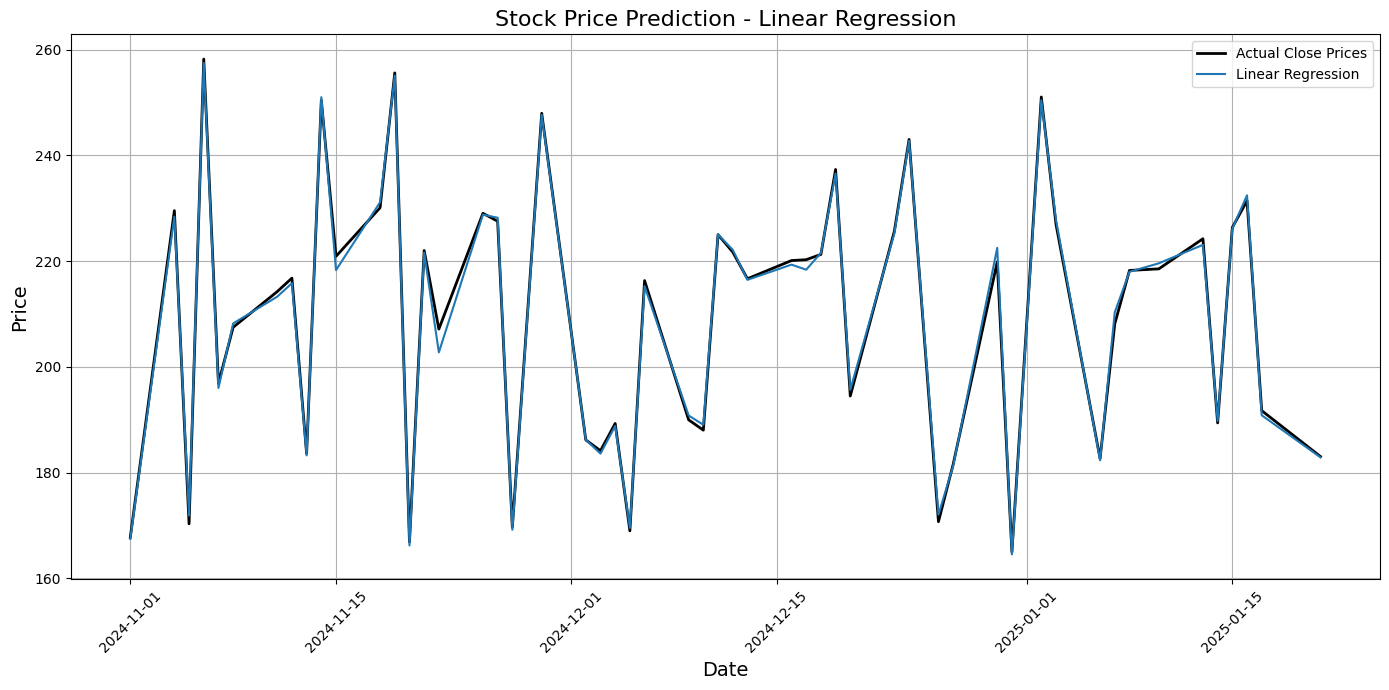

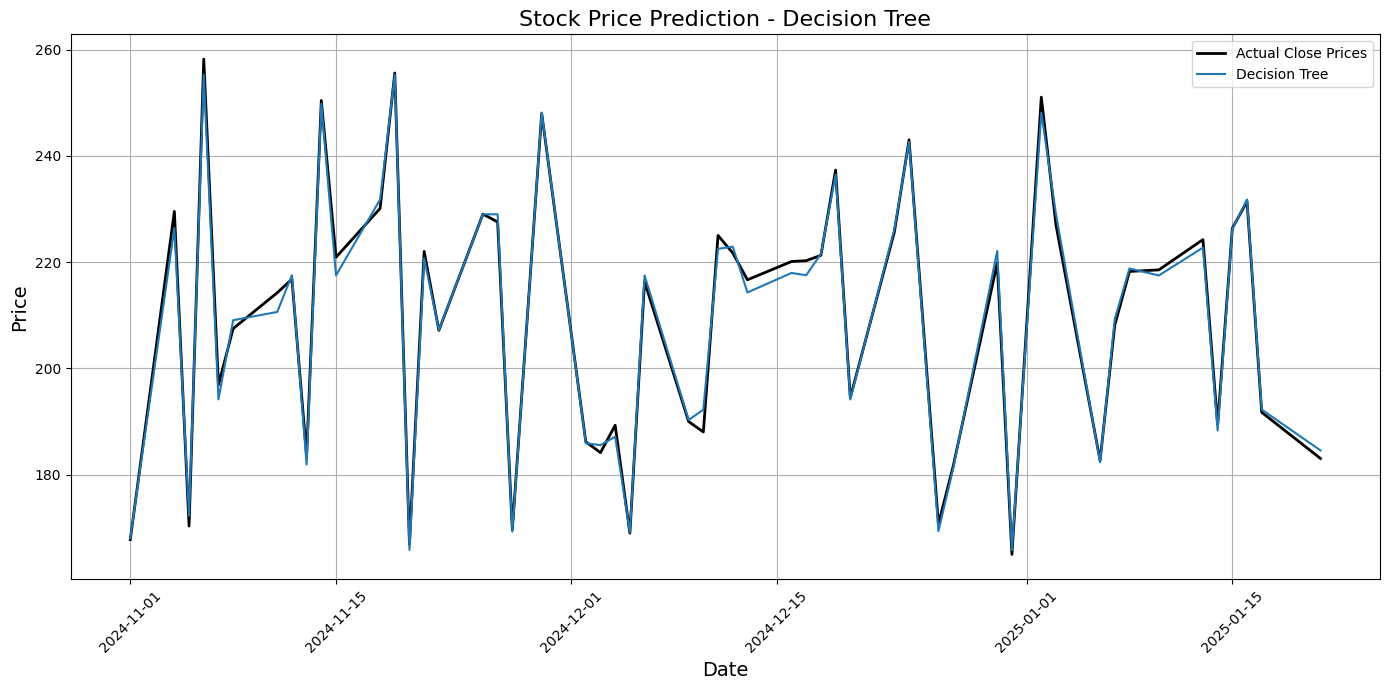

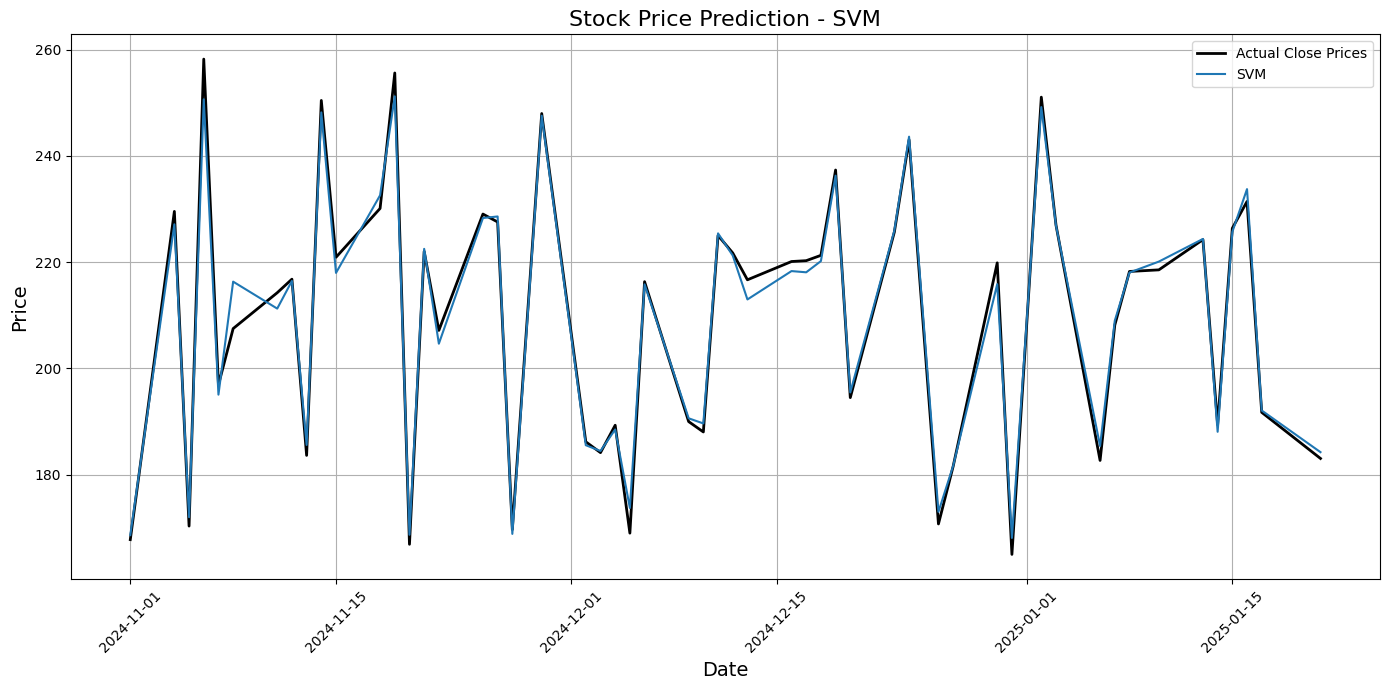

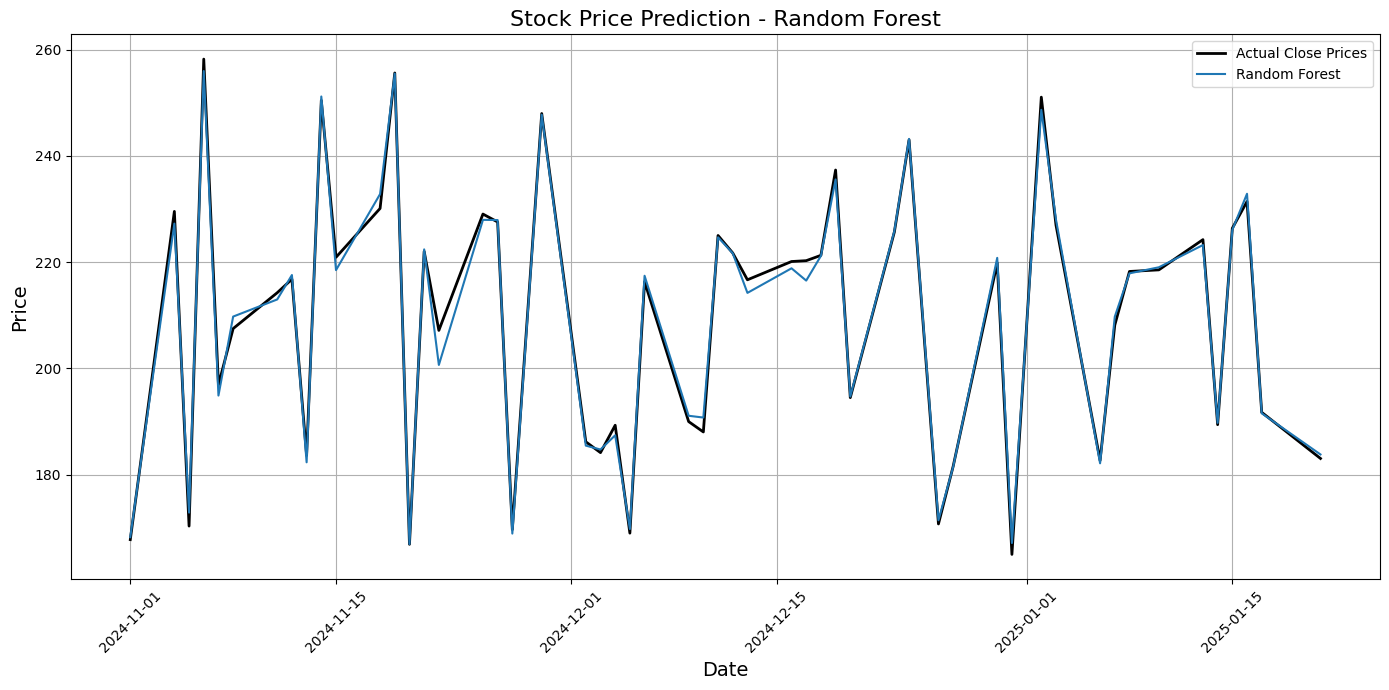

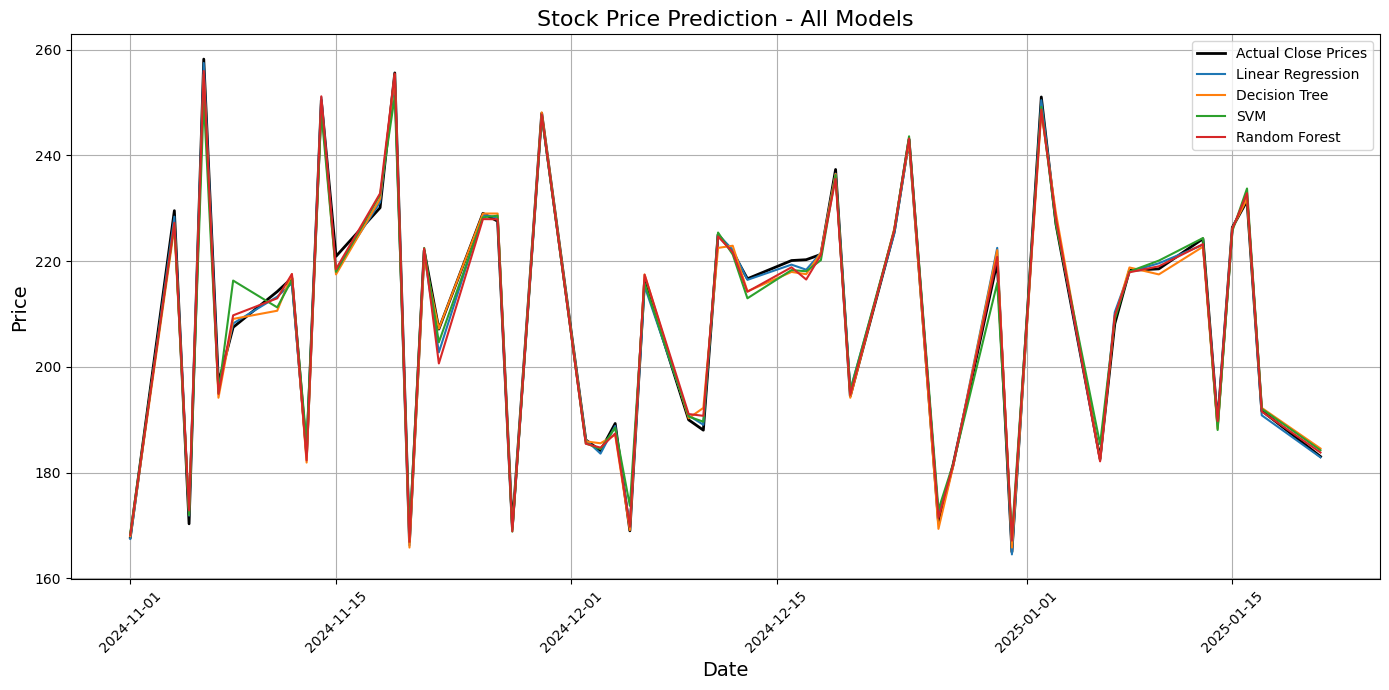

In [10]:
# Imputation for filling missing values
imputer = SimpleImputer(strategy='mean')   # Choosing imputation strategy
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Normalizing features
scaler = StandardScaler()

# Normalizing for linear model
X_train_lr = scaler.fit_transform(X_train)
X_test_lr = scaler.transform(X_test)

# Normalizing for decision tree model
X_train_dt = scaler.fit_transform(X_train)
X_test_dt = scaler.transform(X_test)

# Normalizing for SVM model
X_train_svm = scaler.fit_transform(X_train)
X_test_svm = scaler.transform(X_test)

# Normalizing for random forest model
X_train_rf = scaler.fit_transform(X_train)
X_test_rf = scaler.transform(X_test)

# Defining models and hyperparameters for Grid Search
models = {
    'Linear Regression': (LinearRegression(), {}),
    'Decision Tree': (DecisionTreeRegressor(), {'max_depth': [None, 5, 10, 15]}),
    'SVM': (SVR(), {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}),
    'Random Forest': (RandomForestRegressor(n_estimators=100), {'max_depth': [None, 5, 10, 15], 'min_samples_split': [2, 5]})
}

# Storing results
results = {}

# Training and evaluating each model
for name, (model, params) in models.items():
    if name == 'Linear Regression':
        X_train_model = X_train_lr
        X_test_model = X_test_lr
    elif name == 'Decision Tree':
        X_train_model = X_train_dt
        X_test_model = X_test_dt
    elif name == 'SVM':
        X_train_model = X_train_svm
        X_test_model = X_test_svm
    elif name == 'Random Forest':
        X_train_model = X_train_rf
        X_test_model = X_test_rf

    # Grid Search
    grid_search = GridSearchCV(model, params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_model, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_model)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mean_cv_score = -grid_search.best_score_  # Convert to positive MSE
    results[name] = (y_pred, mse, mae, r2, mean_cv_score, grid_search.best_params_)


# Defining a list to store results
results_list = []

# Collecting results
for name, (y_pred, mse, mae, r2, mean_cv_score, best_params) in results.items():
    results_list.append({
        'Model': name,
        'MSE': mse,
        'MAE': mae,
        'R²': r2,
        'CV MSE': mean_cv_score,
        'Best Params': str(best_params) # Convert to string for storage
    })

# Creating DataFrame from the results list
results_df = pd.DataFrame(results_list)

# Displaying the results table
print(results_df)

# Saving output to a CSV file
results_df.to_csv('stock_price_prediction_results.csv', index=False)

# Optionally save to an Excel file
# results_df.to_excel('stock_price_prediction_results.xlsx', index=False)

# Plotting results for each model separately
for name, (y_pred, mse, mae, r2, mean_cv_score, best_params) in results.items():
    plt.figure(figsize=(14, 7))
    
    # Actual data
    plt.plot(data.index[-len(y_test):], y_test, color='black', label='Actual Close Prices', linewidth=2)
    
    # Model predictions
    plt.plot(data.index[-len(y_test):], y_pred, label=name, linewidth=1.5)
    
    # Improving chart readability
    plt.title(f'Stock Price Prediction - {name}', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Price', fontsize=14)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plotting a combined chart for all models
plt.figure(figsize=(14, 7))

# Actual data
plt.plot(data.index[-len(y_test):], y_test, color='black', label='Actual Close Prices', linewidth=2)

# Predictions from all models
for name, (y_pred, _, _, _, _, _) in results.items():
    plt.plot(data.index[-len(y_test):], y_pred, label=name, linewidth=1.5)

# Improving overall chart readability
plt.title('Stock Price Prediction - All Models', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()  # Prevent title clipping
plt.show()

# Section 2: Examining correlation between features
# Feature selection

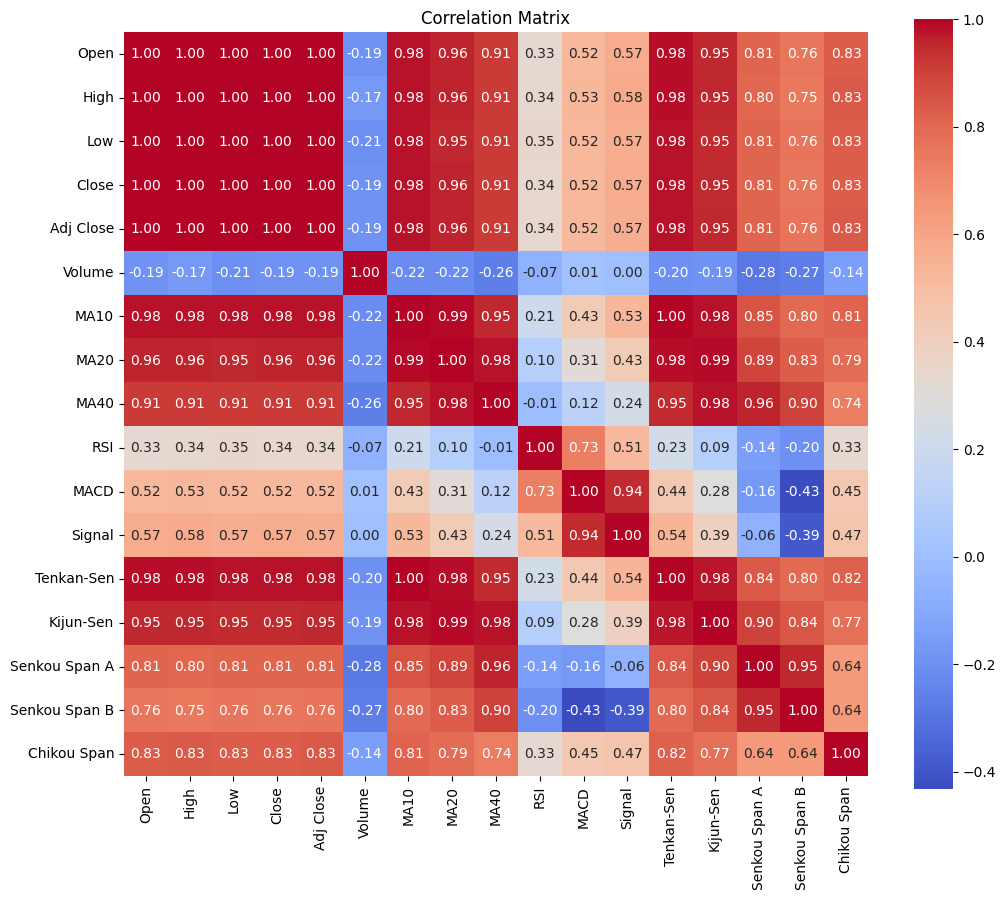

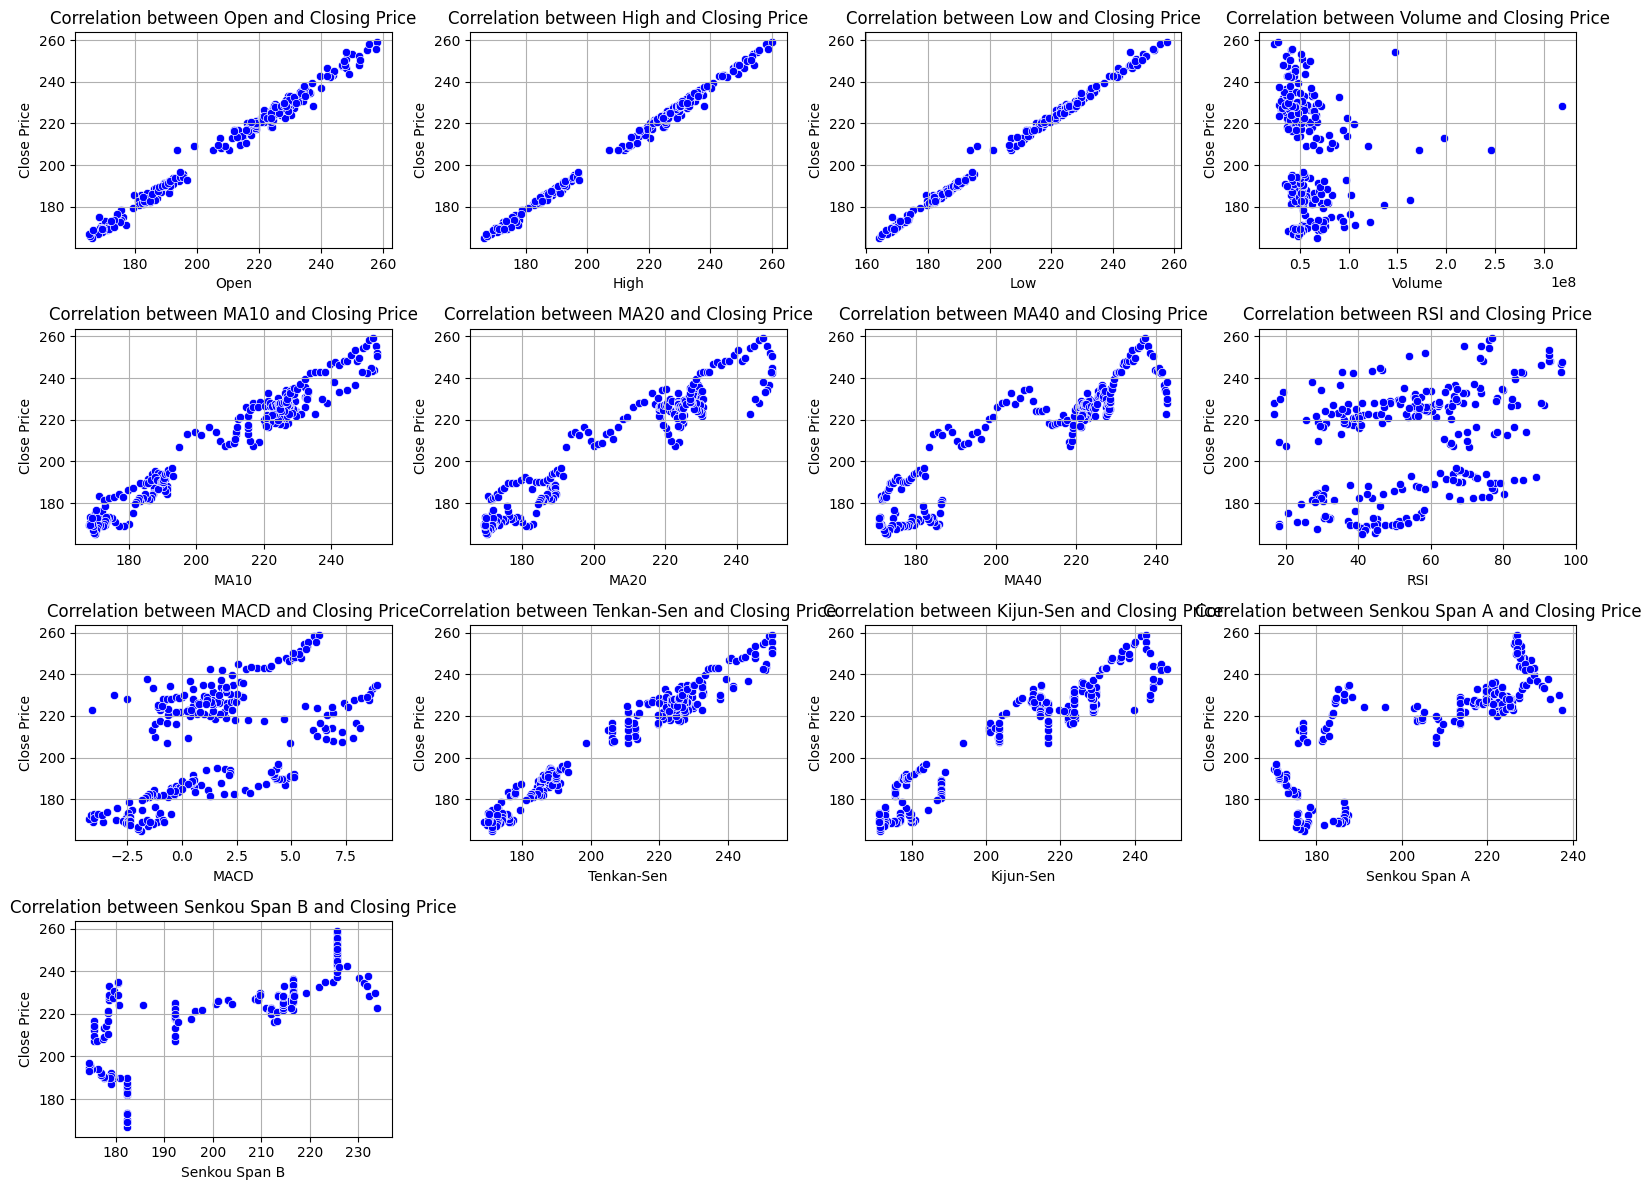

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculating the correlation matrix
correlation_matrix = data.corr()

# Displaying the correlation matrix visually
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix')
plt.show()

# Features for analyzing correlation with closing price
features = ['Open', 'High', 'Low', 'Volume', 'MA10', 'MA20', 'MA40', 'RSI', 'MACD', 'Tenkan-Sen', 'Kijun-Sen', 'Senkou Span A', 'Senkou Span B']

# Number of features
num_features = len(features)

# Creating subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 12))
axes = axes.flatten()  # Flattening the 2D array to 1D for easier access

# Analyzing correlation between each feature and closing price
for i, feature in enumerate(features):
    sns.scatterplot(data=data, x=feature, y='Close', color='blue', ax=axes[i])
    axes[i].set_title(f'Correlation between {feature} and Closing Price')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Close Price')
    axes[i].grid()

# Removing unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# After examining correlation, we will add feature selection code

# Feature selection

In [17]:
# Selecting features with high correlation above 0.5 or below -0.5
threshold = 0.5
strong_correlations = correlation_matrix['Close'][abs(correlation_matrix['Close']) > threshold].index.tolist()

# Removing closing price from the list of features
strong_correlations.remove('Close')

print("Selected features based on correlation with Closing Price:")
print(strong_correlations)

# Step 6: Features and target variable
X = data[strong_correlations]
y = data['Close']


Selected features based on correlation with Closing Price:
['Open', 'High', 'Low', 'Adj Close', 'MA10', 'MA20', 'MA40', 'MACD', 'Signal', 'Tenkan-Sen', 'Kijun-Sen', 'Senkou Span A', 'Senkou Span B', 'Chikou Span']


               Model       MSE       MAE        R²    CV MSE  \
0  Linear Regression  0.008276  0.075822  0.999987  0.008505   
1      Decision Tree  0.734771  0.615095  0.998856  1.699209   
2                SVM  4.386281  1.361088  0.993174  3.697053   
3      Random Forest  1.137066  0.607807  0.998230  1.338800   

                                 Best Params  
0                                         {}  
1                          {'max_depth': 15}  
2                 {'C': 10, 'gamma': 'auto'}  
3  {'max_depth': 15, 'min_samples_split': 2}  


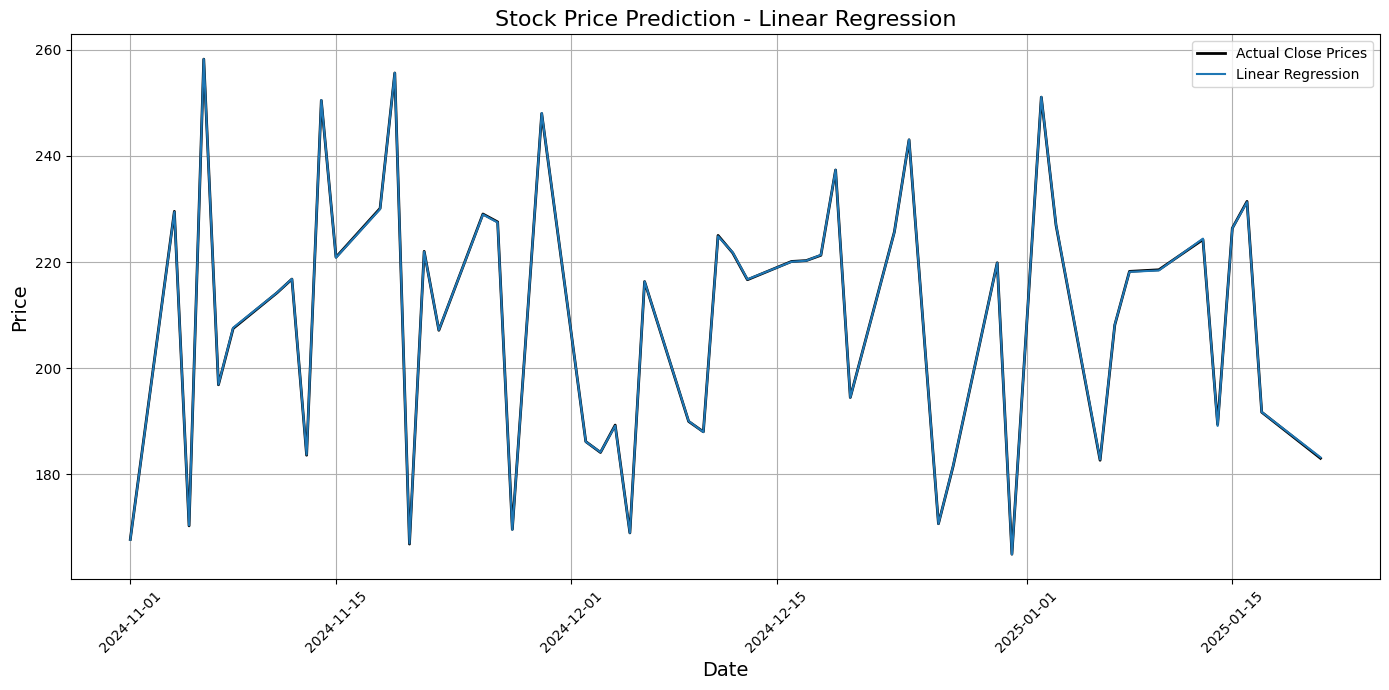

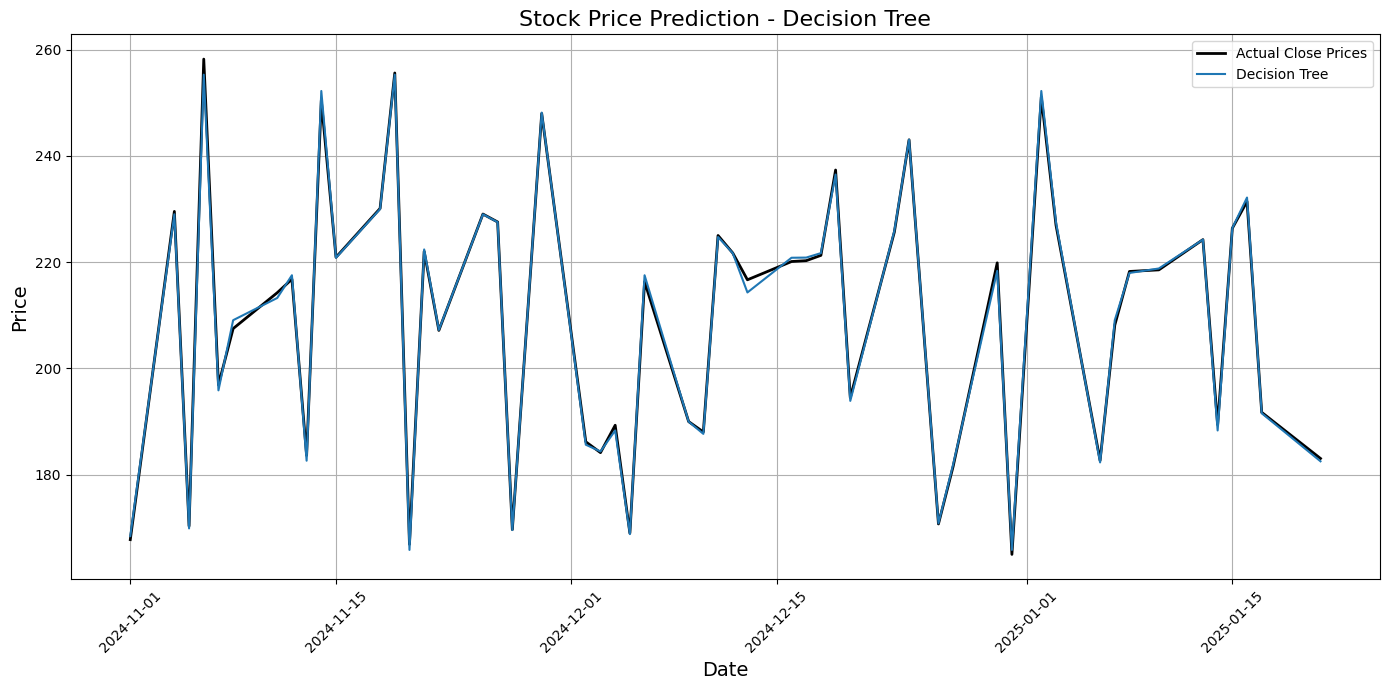

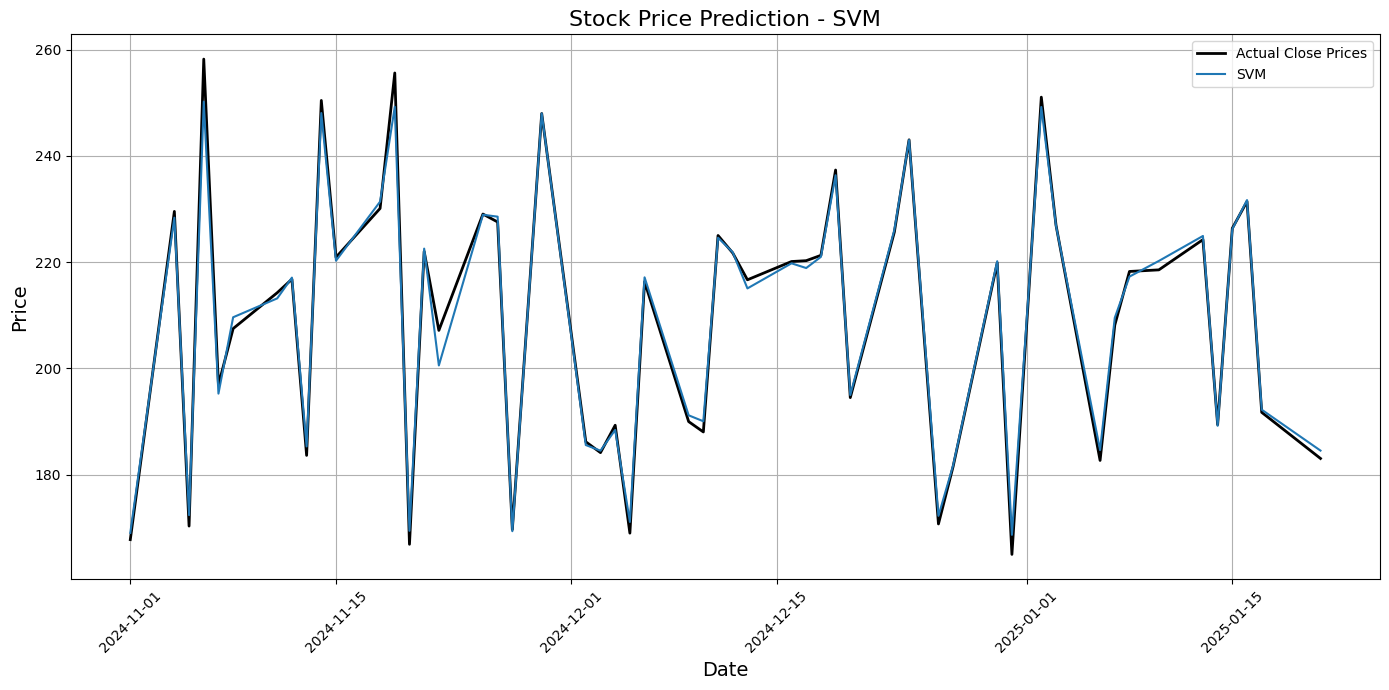

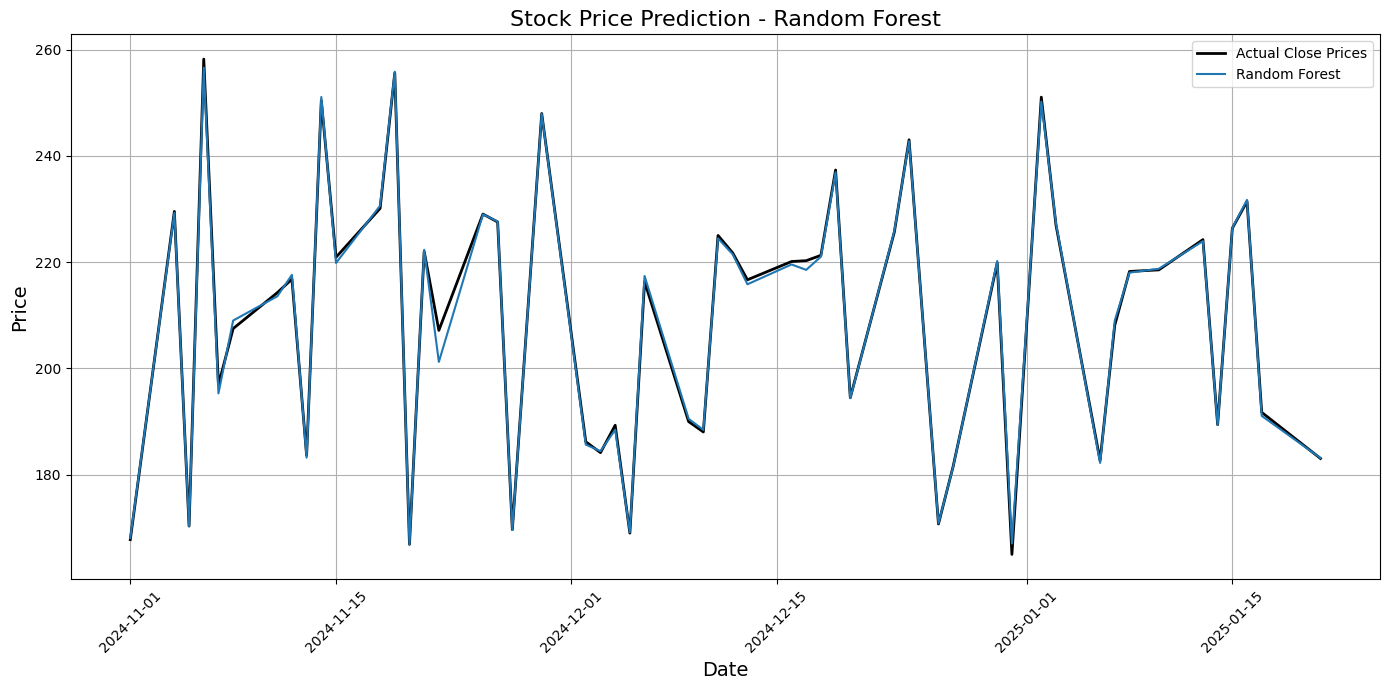

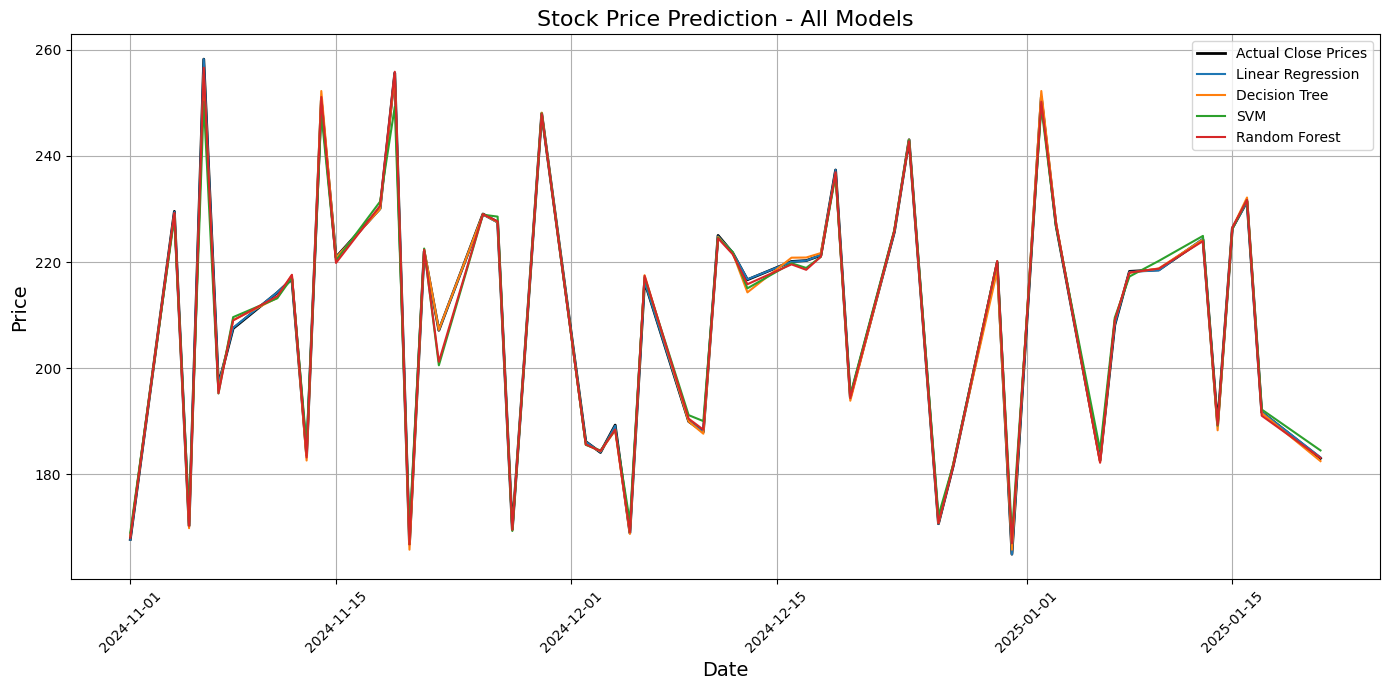

In [18]:
# Step 7: Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 8: Normalizing features
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Normalizing features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Defining models and hyperparameters for Grid Search
models = {
    'Linear Regression': (LinearRegression(), {}),
    'Decision Tree': (DecisionTreeRegressor(), {'max_depth': [None, 5, 10, 15]}),
    'SVM': (SVR(), {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}),
    'Random Forest': (RandomForestRegressor(n_estimators=100), {'max_depth': [None, 5, 10, 15], 'min_samples_split': [2, 5]})
}

# Storing results
results = {}

# Training and evaluating each model
for name, (model, params) in models.items():
    grid_search = GridSearchCV(model, params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mean_cv_score = -grid_search.best_score_
    results[name] = (y_pred, mse, mae, r2, mean_cv_score, grid_search.best_params_)

# Defining a list to store results
results_list = []

# Collecting results
for name, (y_pred, mse, mae, r2, mean_cv_score, best_params) in results.items():
    results_list.append({
        'Model': name,
        'MSE': mse,
        'MAE': mae,
        'R²': r2,
        'CV MSE': mean_cv_score,
        'Best Params': str(best_params)
    })

# Creating DataFrame from the results list
results_df = pd.DataFrame(results_list)

# Displaying the results table
print(results_df)

# Saving output to a CSV file
results_df.to_csv('stock_price_prediction_results.csv', index=False)

# Plotting results for each model separately
for name, (y_pred, mse, mae, r2, mean_cv_score, best_params) in results.items():
    plt.figure(figsize=(14, 7))
    
    # Actual data
    plt.plot(data.index[-len(y_test):], y_test, color='black', label='Actual Close Prices', linewidth=2)
    
    # Model predictions
    plt.plot(data.index[-len(y_test):], y_pred, label=name, linewidth=1.5)
    
    # Improving chart readability
    plt.title(f'Stock Price Prediction - {name}', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Price', fontsize=14)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plotting a combined chart for all models
plt.figure(figsize=(14, 7))

# Actual data
plt.plot(data.index[-len(y_test):], y_test, color='black', label='Actual Close Prices', linewidth=2)

# Predictions from all models
for name, (y_pred, _, _, _, _, _) in results.items():
    plt.plot(data.index[-len(y_test):], y_pred, label=name, linewidth=1.5)

# Improving overall chart readability
plt.title('Stock Price Prediction - All Models', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()   # Prevent title clipping
plt.show()